In [2]:
import pandas as pd
import numpy as np
import os
import pickle
from Bio import SeqIO
import re
from ete3 import Tree
import matplotlib.pyplot as plt

plt.style.use("ggplot")
import seaborn as sns

import time
from datetime import datetime
from time import mktime

import json

fontsize = 24
plt.rcParams.update({"font.size": fontsize, "font.weight": "normal", "axes.grid": False, "savefig.transparent": False})
sns.set_style("white")
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]
nbins = 10

In [3]:
with_model_weighting = True

group_by_options = ["genus", "family", "time_5", "time_10", "time_20"]
add_missing_options = {False: "include_missing", True: "include_all_possible_missing"}
chromevol_workdir = f"../chromevol/{'with_model_weighting/' if with_model_weighting else ''}"
results_dir = f"../chromevol/results/{'with_model_weighting/' if with_model_weighting else 'without_model_weighting/'}"
wfo_classification_path = "../wfo_classification.txt"
tpl_classification_path = "../tpl.csv"
cots_classification_path = "../chromevol/results/cots_classification/cots_classification.csv"
ccdb_path = "../ccdb_all_data_171122.csv"
ott_genus_results_path = "../chromevol/results/one_two_tree/genus_db.csv"
ott_family_results_path = "../chromevol/results/one_two_tree/family_db.csv"
os.makedirs(results_dir, exist_ok=True)

In [4]:
wfo_classification_data = pd.read_csv(wfo_classification_path, sep="\t")
tpl_classification_data = pd.read_csv(tpl_classification_path)
wfo_accepted_classification_data = wfo_classification_data.query("taxonomicStatus == 'ACCEPTED'")
tpl_accepted_classification_data = tpl_classification_data.query("Status == 'Accepted'")
wfo_accepted_classification_data = wfo_classification_data.query("taxonomicStatus == 'ACCEPTED'")
tpl_accepted_classification_data = tpl_classification_data.query("Status == 'Accepted'")
tpl_accepted_classification_data = tpl_classification_data.query("Status == 'Accepted'")
diff = wfo_accepted_classification_data.shape[0] - tpl_accepted_classification_data.shape[0]
classification_data = wfo_accepted_classification_data if diff > 50000 else tpl_accepted_classification_data

/tmp/ipykernel_20599/291537002.py:1: DtypeWarning: Columns (2,8,9,10,12,13,14,15,16,20,21,23,24,28) have mixed types. Specify dtype option on import or set low_memory=False.
  wfo_classification_data = pd.read_csv(wfo_classification_path, sep="\t")


In [5]:
ott_db = {"genus": pd.read_csv(ott_genus_results_path), "family": pd.read_csv(ott_family_results_path)}

In [6]:
for gb in ott_db:
    db = ott_db[gb]
    db = db.loc[(~db.Family.isin(["cyperaceae"])) & (~db.Genus.isin(["cuscuta", "luzula", "drosera"]))]
    ott_db[gb] = db
    print(
        f"for {gb}-scale, for {ott_db[gb].loc[ott_db[gb]['Ploidy inference'].isna()].shape[0]:,} taxa, ploidy levels could not be reliably determined"
    )

for genus-scale, for 777 taxa, ploidy levels could not be reliably determined
for family-scale, for 97 taxa, ploidy levels could not be reliably determined


In [7]:
ccdb = pd.read_csv(ccdb_path)
ccdb.family = ccdb.family.str.lower()

classification_data.genus = classification_data.genus.str.lower()
classification_data.family = classification_data.family.str.lower()
classification_data.majorGroup = classification_data.majorGroup.str.lower().replace(
    {"a": "angiosperms", "g": "gymnosperms", "b": "bryophytes", "p": "pteridophytes"}
)
classification_data["taxon"] = classification_data.scientificName.str.lower()
classification_data_by_major_group = classification_data.groupby("majorGroup")

name_to_genus = classification_data.set_index("taxon")["genus"].to_dict()
name_to_family = classification_data.set_index("taxon")["family"].to_dict()
genus_to_family = classification_data.set_index("genus")["family"].to_dict()
family_to_major_group = classification_data.set_index("family")["majorGroup"].to_dict()
angio_families = (
    classification_data.query("majorGroup == 'angiosperms'")
    .groupby("family")["taxonID"]
    .count()
    .reset_index()
    .sort_values("taxonID", ascending=False)
)
angio_families.rename(columns={"taxonID": "num_accepted_names"}, inplace=True)


def get_ccdb_coverage(family: str) -> int:
    fam_ccdb = ccdb.query(f"family == '{family}'")
    num_covered_names = len(fam_ccdb.mapped_name.unique().tolist())
    return num_covered_names


/tmp/ipykernel_20599/1443980149.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_data.genus = classification_data.genus.str.lower()
/tmp/ipykernel_20599/1443980149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_data.family = classification_data.family.str.lower()
/tmp/ipykernel_20599/1443980149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

# report coverage across phylognetic scales

In [8]:
# extract the inferred ploidy thresholds
def get_thresholds(log_path: str, fixed: bool = True) -> tuple[float, float, float, float]:
    polyploidy_threshold, diplodiy_threshold, polyploidy_coeff, diplodiy_coeff = np.nan, np.nan, np.nan, np.nan
    thresholds_matcher = re.compile(
        "determining ploidy level based on the fixed diploidy and polyploidy thresholds (\d*\.*\d*) and (\d*\.*\d*)"
    )
    if not fixed:
        thresholds_matcher = re.compile(
            "\(coeff=(\d*\.?\d*)\)\n.*?final selected .*?ploidy threshold with the same coeff\s=\s(.*?)\n", re.DOTALL
        )
    if not os.path.exists(log_path):
        return np.nan, np.nan, np.nan, np.nan
    with open(log_path, "r") as file:
        log = file.read()
    matches = [m for m in thresholds_matcher.finditer(log)]
    if len(matches) < 1 if fixed else 2:
        return np.nan, np.nan, np.nan, np.nan
    if fixed:
        diploidy_threshold = matches[-1].group(1)
        polyploidy_threshold = matches[-1].group(2)
    else:
        polyploidy_threshold, polyploidy_coeff = float(matches[-2].group(2)), float(matches[-2].group(1))
        diplodiy_threshold, diplodiy_coeff = float(matches[-1].group(2)), float(matches[-1].group(1))
    return polyploidy_threshold, diplodiy_threshold, polyploidy_coeff, diplodiy_coeff


def get_selected_model(log_path: str) -> str:
    model_matcher = re.compile("the selected model is .*?model_selection/(.*?)//parsed_output.json with a score of")
    model_name_to_id = {
        "gain_loss": "M0",
        "gain_loss_dupl": "M1",
        "gain_loss_dupl_demiPloidyR": "M2",
        "gain_loss_baseNum_baseNumR": "M3",
        "gain_loss_dupl_baseNum_baseNumR": "M4",
        "gain_loss_dupl_baseNum_baseNumR_demiPloidyR": "M5",
    }
    if not os.path.exists(log_path):
        return np.nan
    with open(log_path, "r") as file:
        log = file.read()
    try:
        selected_model_name = model_matcher.search(log).group(1)
        selected_model_id = model_name_to_id[selected_model_name]
        return selected_model_id
    except:
        return np.nan


def get_model_parameters(sm_input_json_path: str, ml_tree_path: str) -> dict:
    if not os.path.exists(sm_input_json_path):
        return pd.DataFrame()
    parameter_names = ["baseNum", "baseNumR", "dupl", "loss", "gain", "demiPloidyR", "root_cn"]
    parameters = dict()
    with open(sm_input_json_path, "r") as f:
        sm_input = json.load(f)
    for parameter_name in parameter_names:
        parameters[parameter_name] = sm_input["parameters"].get(parameter_name, np.nan)
    if not os.path.exists(ml_tree_path):
        # print(f"path {ml_tree_path} does not exist")
        parameters["root_cn"] = np.nan
    else:
        ml_tree = Tree(ml_tree_path, format=1)
        root_name = ml_tree.name
        root_number = int(root_name.split("-")[-1])
        parameters["root_cn"] = root_number
    return parameters


def get_output_flag(out_path: str) -> str:
    if "include_missing" in out_path:
        raise ValueError(f"deprecated path {out_path}")
    with open(log_path, "r") as f:
        c = f.read()
    if "PBS: job killed: mem" in c:
        return "failed due to memory error"
    elif "PBS: job killed: ncpus" in c:
        return "failed due to cpu error"
    elif "Mapping failure!" in c or "less than 80.0% of the mappings were successful, and so the script will halt":
        return "failed due to mappings"
    return "failed due to other error"


def add_taxonomic_classification(db: pd.DataFrame) -> pd.DataFrame:
    db.Family = db.Family.str.lower()
    db.Genus = db.Genus.str.lower()
    db.set_index("Genus", inplace=True)
    db.Family.fillna(genus_to_family, inplace=True)
    db.reset_index(inplace=True)
    db.set_index("Family", inplace=True)
    db["major_group"] = np.nan
    db.major_group.fillna(family_to_major_group, inplace=True)
    db.reset_index(inplace=True)
    return db


In [11]:
comb_to_db = dict()
for am in add_missing_options:
    comb_to_db[am] = dict()
    if not am or am and gb == "genus":
        print(
            f"\n\n###########################################\n############# with{'' if am else 'out'} missing ################\n###########################################"
        )
    for gb in group_by_options:
        if not am or am and gb == "genus":
            print(f"\n########## group by = {gb} ###############")
        suffix = "_include_all_possible_missing" if am else ""
        input_dir = f"{chromevol_workdir}by_{gb}_on_unresolved_ALLMB_and_unresolved_ccdb{suffix}/"
        if not os.path.exists(input_dir):
            continue
        print(f"input_dir={input_dir}")
        db_path = f"{results_dir}ploidb_by_{gb}_with{'' if am else 'out'}_missing.csv"
        print(f"db_path={db_path}")
        if os.path.exists(db_path):
            db = pd.read_csv(db_path)
        else:
            dfs = []
            total_count = 0
            for path in os.listdir(input_dir):
                if ".ipy" in path or not os.path.isdir(f"{input_dir}{path}"):
                    continue
                if os.path.exists(f"{input_dir}/{path}/new_counts.fata"):
                    os.remove(f"{input_dir}/{path}/new_counts.fata")
                total_count += 1
                sm_dir = f"{input_dir}/{path}/chromevol/stochastic_mapping/stochastic_mappings/"
                out_path = f"{input_dir}{path}/chromevol/ploidy.csv"
                log_path = f"{input_dir}{path}/chromevol.out"
                logger_path = f"{input_dir}{path}/pipeline.log"
                model_scores_regex = re.compile("model=(.*?)\shas score of (\d*\.?\d*)")

                output_flag = "standard"
                if not os.path.exists(log_path):
                    tree_path = f"{input_dir}{path}/tree.nwk"
                    if not os.path.exists(tree_path):
                        print(f"faulty dir in {input_dir}{path}")
                        continue
                    counts_path = f"{input_dir}{path}/counts.fasta"
                    counts_data = {
                        record.description: str(record.seq) for record in list(SeqIO.parse(counts_path, format="fasta"))
                    }
                    failed_taxa = list(counts_data.keys())
                    failed_df = pd.DataFrame(
                        {
                            "Taxon": failed_taxa,
                            "Chromosome count": [counts_data[t] for t in failed_taxa],
                            "Genus": path if gb == "genus" else [name_to_genus.get(tax, np.nan) for tax in failed_taxa],
                            "Family": path
                            if gb == "family"
                            else [name_to_family.get(tax, np.nan) for tax in failed_taxa],
                            gb: path,
                            "flag": "incomplete job",
                        }
                    )
                    dfs.append(failed_df)
                    continue
                new_exists = not os.path.exists(f"{input_dir}{path}/stochastic_mapping/")
                if os.path.exists(log_path) and not os.path.exists(out_path):
                    counts_path = f"{input_dir}{path}/counts.fasta"
                    counts_data = {
                        record.description: str(record.seq) for record in list(SeqIO.parse(counts_path, format="fasta"))
                    }
                    failed_taxa = list(counts_data.keys())
                    output_flag = get_output_flag(log_path)
                    failed_df = pd.DataFrame(
                        {
                            "Taxon": failed_taxa,
                            "Chromosome count": [counts_data[t] for t in failed_taxa],
                            "Genus": path if gb == "genus" else [name_to_genus.get(tax, np.nan) for tax in failed_taxa],
                            "Family": path
                            if gb == "family"
                            else [name_to_family.get(tax, np.nan) for tax in failed_taxa],
                            gb: path,
                            "flag": output_flag,
                        }
                    )
                    dfs.append(failed_df)
                if os.path.exists(out_path):
                    df = pd.read_csv(out_path)
                    if gb in ["genus", "family"]:
                        ott_data = ott_db[gb]
                        taxon_to_flag = {}
                        for tax in df.Taxon:
                            flag = np.nan
                            our_plevel = df.loc[df.Taxon == tax, "Ploidy inference"].values[0]
                            ott_plevel = ott_data.loc[ott_data.Taxon == tax, "Ploidy inference"]
                            if ott_plevel.shape[0] > 0:
                                ott_plevel = ott_plevel.values[0]
                                flag = ott_plevel == our_plevel
                                taxon_to_flag[tax] = flag
                        df["Phylogenetically reliable"] = df.Taxon.apply(lambda t: taxon_to_flag.get(t, np.nan))
                        df.to_csv(out_path)
                    labels = df["Ploidy inference"].unique().tolist()
                    if len(labels) == 1:
                        output_flag = f"inferred only {'di' if labels[0] == 0 else 'poly'}ploids"
                    df[gb] = path
                    df[
                        ["polyploidy_threshold", "diploidy_threshold", "polyploidy_coeff", "diploidy_coeff"]
                    ] = get_thresholds(f"{input_dir}{path}/pipeline.log")
                    df["selected_model"] = get_selected_model(f"{input_dir}{path}/pipeline.log")
                    sm_dir = f"{input_dir}{path}/chromevol/stochastic_mapping_model_with_base_num/"
                    if not os.path.exists(sm_dir):
                        sm_dir = f"{input_dir}{path}/chromevol/stochastic_mapping/"
                    model_parameters = get_model_parameters(
                        sm_input_json_path=f"{sm_dir}/sm_params.json",
                        ml_tree_path=f"{sm_dir}/MLAncestralReconstruction.tree",
                    )
                    for p in model_parameters:
                        df[p] = model_parameters[p]
                    jp = f"{input_dir}{path}/chromevol.sh"
                    df["flag"] = output_flag

                try:
                    if os.path.exists(logger_path):
                        with open(logger_path, "r") as f:
                            logger = f.read()
                        model_to_score = {
                            match.group(1): float(match.group(2)) for match in model_scores_regex.finditer(logger)
                        }
                        scores = list(model_to_score.values())
                        if len(scores) > 0:
                            max_diff = np.max(scores) - np.min(scores)
                            df["max_delta_aicc"] = max_diff
                except:
                    df["max_delta_aicc"] = np.nan
                dfs.append(df)
            print(f"# original clades = {len(dfs):,}")
            dfs_to_regard = [df for df in dfs if df.shape[0] >= 5]
            print(f"# clades with at least 5 taxa = {len(dfs_to_regard):,}")
            db = pd.concat(dfs_to_regard)
            db.loc[db.Taxon == "olearia albida var. angulata", "Chromosome count"] = 216
            db.loc[db.Taxon == "sedum suaveolens", "Chromosome count"] = 320
            db = add_taxonomic_classification(db)
            db.Family = db.Family.replace({"agavaceae": "asparagaceae", "compositae": "asteraceae"})
            db = db.loc[
                (~db.Family.isin(["cyperaceae"])) & (~db.Genus.isin(["cuscuta", "luzula", "drosera"]))
            ]  # drop cyperaceae from the analysis
            db.to_csv(db_path, index=False)
        print(f"# taxa = {db.shape[0]:,}")
        comb_to_db[am][gb] = db
        print(f"# clades remaining after holocentric filtering = {len(db[gb].unique()):,}")
        print(
            f"# taxa for which ploidy levels could be reliably determined = {db.loc[db['Ploidy inference'].notna()].shape[0]:,}"
        )
        print(
            f"# taxa for which ploidy levels could not be reliably determined = {db.loc[db['Ploidy inference'].isna()].shape[0]:,}"
        )
        if gb in ["genus", "family"]:
            intersection_db = db.dropna(subset=["Phylogenetically reliable"])
            ott_data = ott_db[gb]
            ott_inter_data = ott_data.loc[ott_data.Taxon.isin(intersection_db.Taxon)]
            ott_classfication_data = (
                ott_inter_data.dropna(subset=["Ploidy inference"]).set_index("Taxon")["Ploidy inference"].to_dict()
            )
            print(
                f"# taxa available in OTT as well = {intersection_db.shape[0]:,} across {len(db.dropna(subset=['Phylogenetically reliable'])[gb].unique()):,} {gb} items"
            )
            print(
                f"# taxa in agreement = {intersection_db.loc[intersection_db['Phylogenetically reliable'] == True].shape[0]:,}"
            )
            print(
                f"# intersection taxa for which ploidy levels could not be reliably determined in our db = {intersection_db.loc[intersection_db['Ploidy inference'].isna()].shape[0]:,}"
            )
            print(
                f"# intersection taxa for which ploidy levels could not be reliably determined in ott db = {ott_inter_data.loc[ott_inter_data['Ploidy inference'].isna()].shape[0]:,}"
            )
            print(
                f"% agreement = {np.round(intersection_db.loc[intersection_db['Phylogenetically reliable'] == True].shape[0]/intersection_db.shape[0]*100, 2)}%"
            )
            print(
                f"# contradictions = {intersection_db.loc[intersection_db['Phylogenetically reliable'] == False].shape[0]:,}"
            )
            intersection_db["ott_pl"] = np.nan
            intersection_db.set_index("Taxon", inplace=True)
            intersection_db["ott_pl"].fillna(value=ott_classfication_data, inplace=True)
            hard_contra_db = intersection_db.dropna(subset=["ott_pl", "Ploidy inference"])
            hard_contra_num = hard_contra_db.loc[hard_contra_db.ott_pl != hard_contra_db["Ploidy inference"]].shape[0]
            soft_contra_num = (
                intersection_db.loc[intersection_db["Phylogenetically reliable"] == False].shape[0] - hard_contra_num
            )
            print(f"# soft_contradictions = {soft_contra_num:,} hard contradictions = {hard_contra_num:,}")
        display(db.groupby("flag")[gb].apply(lambda x: len(x.unique())).reset_index().rename(columns={gb: "#clades"}))



###########################################
############# without missing ################
###########################################

########## group by = genus ###############
input_dir=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/with_model_weighting/by_genus_on_unresolved_ALLMB_and_unresolved_ccdb/
db_path=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/with_model_weighting/ploidb_by_genus_without_missing.csv
# taxa = 57,424
# clades remaining after holocentric filtering = 2,062
# taxa for which ploidy levels could be reliably determined = 56,595
# taxa for which ploidy levels could not be reliably determined = 829
# taxa available in OTT as well = 51,122 across 1,572 genus items
# taxa in agreement = 49,369
# intersection taxa for which ploidy levels could not be reliably determined in our db = 686
# intersection taxa for which ploidy levels could not be reliably determined in ott db = 727
% agreement = 96.57%
# contradictions = 1,753
# soft_contradictions = 1,1

/tmp/ipykernel_20599/1428460787.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_db["ott_pl"] = np.nan
/tmp/ipykernel_20599/1428460787.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_db["ott_pl"].fillna(value=ott_classfication_data, inplace=True)


,flag,#clades
0,inferred only diploids,708
1,inferred only polyploids,2
2,standard,1352



########## group by = family ###############
input_dir=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/with_model_weighting/by_family_on_unresolved_ALLMB_and_unresolved_ccdb/
db_path=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/with_model_weighting/ploidb_by_family_without_missing.csv
# taxa = 66,296
# clades remaining after holocentric filtering = 246
# taxa for which ploidy levels could be reliably determined = 63,168
# taxa for which ploidy levels could not be reliably determined = 3,128
# taxa available in OTT as well = 6,242 across 138 family items
# taxa in agreement = 5,132
# intersection taxa for which ploidy levels could not be reliably determined in our db = 346
# intersection taxa for which ploidy levels could not be reliably determined in ott db = 94
% agreement = 82.22%
# contradictions = 1,110
# soft_contradictions = 423 hard contradictions = 687


/tmp/ipykernel_20599/1428460787.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_db["ott_pl"] = np.nan
/tmp/ipykernel_20599/1428460787.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_db["ott_pl"].fillna(value=ott_classfication_data, inplace=True)


,flag,#clades
0,inferred only diploids,39
1,inferred only polyploids,7
2,standard,200



########## group by = time_5 ###############
input_dir=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/with_model_weighting/by_time_5_on_unresolved_ALLMB_and_unresolved_ccdb/
db_path=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/with_model_weighting/ploidb_by_time_5_without_missing.csv
# taxa = 25,641
# clades remaining after holocentric filtering = 1,330
# taxa for which ploidy levels could be reliably determined = 25,418
# taxa for which ploidy levels could not be reliably determined = 223


,flag,#clades
0,inferred only diploids,536
1,inferred only polyploids,3
2,standard,791



########## group by = time_10 ###############
input_dir=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/with_model_weighting/by_time_10_on_unresolved_ALLMB_and_unresolved_ccdb/
db_path=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/with_model_weighting/ploidb_by_time_10_without_missing.csv
# taxa = 42,065
# clades remaining after holocentric filtering = 1,432
# taxa for which ploidy levels could be reliably determined = 41,434
# taxa for which ploidy levels could not be reliably determined = 631


,flag,#clades
0,inferred only diploids,504
1,inferred only polyploids,1
2,standard,927



########## group by = time_20 ###############
input_dir=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/with_model_weighting/by_time_20_on_unresolved_ALLMB_and_unresolved_ccdb/
db_path=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/with_model_weighting/ploidb_by_time_20_without_missing.csv
# taxa = 56,443
# clades remaining after holocentric filtering = 996
# taxa for which ploidy levels could be reliably determined = 52,100
# taxa for which ploidy levels could not be reliably determined = 4,343


,flag,#clades
0,failed due to mappings,2
1,inferred only diploids,283
2,inferred only polyploids,2
3,standard,709



########## group by = genus ###############
input_dir=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/with_model_weighting/by_genus_on_unresolved_ALLMB_and_unresolved_ccdb_include_all_possible_missing/
db_path=/groups/itay_mayrose/halabikeren/PloiDB/chromevol/results/with_model_weighting/ploidb_by_genus_with_missing.csv


/tmp/ipykernel_20599/1428460787.py:17: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  db = pd.read_csv(db_path)
/tmp/ipykernel_20599/1428460787.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_db["ott_pl"] = np.nan


# taxa = 174,763
# clades remaining after holocentric filtering = 1,367
# taxa for which ploidy levels could be reliably determined = 99,728
# taxa for which ploidy levels could not be reliably determined = 75,035
# taxa available in OTT as well = 42,589 across 1,064 genus items
# taxa in agreement = 40,311
# intersection taxa for which ploidy levels could not be reliably determined in our db = 555
# intersection taxa for which ploidy levels could not be reliably determined in ott db = 645
% agreement = 94.65%
# contradictions = 2,278
# soft_contradictions = 1,079 hard contradictions = 1,199


/tmp/ipykernel_20599/1428460787.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intersection_db["ott_pl"].fillna(value=ott_classfication_data, inplace=True)


,flag,#clades
0,failed due to mappings,7
1,failed due to memory error,1
2,inferred only diploids,15
3,inferred only polyploids,4
4,standard,1340


# create mapping of taxon to directory with results for each phylogenetic time scale

In [15]:
for time in [5, 10, 20]:
    time_wo_missing_dir = f"../chromevol/with_model_weighting/by_time_{time}_on_unresolved_ALLMB_and_unresolved_ccdb/"
    time_w_missing_dir = f"../chromevol/with_model_weighting/by_time_{time}_on_unresolved_ALLMB_and_unresolved_ccdb_include_all_possible_missing/"
    time_taxon_to_outdir_path = f"../chromevol/with_model_weighting/time_{time}_taxon_to_outdir.csv"
    db_wo_missing = comb_to_db[False][f"time_{time}"]
    db_w_missing = comb_to_db[True][f"time_{time}"]
    res_wo_missing = db_wo_missing[["Taxon", f"time_{time}"]].rename(
        columns={"Taxon": "species", f"time_{time}": "dir_standard"}
    )
    res_w_missing = db_w_missing[["Taxon", f"time_{time}"]].rename(
        columns={"Taxon": "species", f"time_{time}": "dir_extended"}
    )
    res = res_wo_missing.merge(res_w_missing, on="species", how="outer")
    res["dir_standard"] = res["dir_standard"].apply(
        lambda x: f"{time_wo_missing_dir}{x}/chromevol/"
        if pd.notna(x) and os.path.exists(f"{time_wo_missing_dir}{x}/chromevol/")
        else np.nan
    )
    res["dir_extended"] = res["dir_extended"].apply(
        lambda x: f"{time_w_missing_dir}{x}/chromevol/"
        if pd.notna(x) and os.path.exists(f"{time_w_missing_dir}{x}/chromevol/")
        else np.nan
    )
    res.to_csv(time_taxon_to_outdir_path)
    print(f"time = {time}")
    display(res.isna().sum())

KeyError: 'time_5'

# debug differences in intersection coverage

In [16]:
genus_level_db = comb_to_db[False]["genus"].dropna(subset=["Ploidy inference"])
family_level_db = comb_to_db[False]["family"].dropna(subset=["Ploidy inference"])
time_20_level_db = comb_to_db[False]["time_20"].dropna(subset=["Ploidy inference"])

genus_family_intersection = set(genus_level_db.Taxon) & set(family_level_db.Taxon)
family_time_20_intersection = set(time_20_level_db.Taxon) & set(family_level_db.Taxon)
intersection_all = genus_family_intersection & family_time_20_intersection
missing_from_time_20_family_intersection = list(genus_family_intersection - family_time_20_intersection)
missing_from_genus_family_intersection = list(family_time_20_intersection - genus_family_intersection)

print(f"# genus_family_intersection = {len(genus_family_intersection):,}")
print(f"# family_time_20_intersection = {len(family_time_20_intersection):,}")
print(f"# missing_from_time_20_family_intersection = {len(missing_from_time_20_family_intersection):,}")
print(f"# missing_from_genus_family_intersection = {len(missing_from_genus_family_intersection):,}")

# genus_family_intersection = 53,583
# family_time_20_intersection = 49,381
# missing_from_time_20_family_intersection = 9,895
# missing_from_genus_family_intersection = 5,693


In [17]:
genera_missing_from_time_20_family_intersection = set(
    [n.split(" ")[0] for n in missing_from_time_20_family_intersection]
)

genus_to_age = {}
for genus in genera_missing_from_time_20_family_intersection:
    t = Tree(f"../chromevol/with_model_weighting/by_genus_on_unresolved_ALLMB_and_unresolved_ccdb/{genus}/tree.nwk")
    age = t.get_distance(t.get_leaves()[0])
    genus_to_age[genus] = age

old_genera = [g for g in genus_to_age if genus_to_age[g] > 20]
suspicious_genera = [g for g in genus_to_age if genus_to_age[g] < 20]
print(
    f"# genera with missing taxa in time-20 family interesection but are younger than 20MYA = {len(suspicious_genera):,}"
)
print(f"other {len(old_genera)} are old genera")

# genera with missing taxa in time-20 family interesection but are younger than 20MYA = 172
other 223 are old genera


In [18]:
family_presence = family_level_db.loc[family_level_db.Genus.isin(suspicious_genera)]
time_20_presence = time_20_level_db.loc[time_20_level_db.Genus.isin(suspicious_genera)]
presence_intersection = set(family_presence.Taxon) & set(time_20_presence.Taxon)

In [19]:
missing_from_time_20 = set(family_presence.Taxon) - set(time_20_presence.Taxon)
only_missing_ploidy_inference = set(comb_to_db[False]["time_20"].Taxon) & missing_from_time_20
print(
    f"out of {len(missing_from_time_20)} taxa present at family level and missing is 20 MYA, {len(only_missing_ploidy_inference)} are actually in 20 MYA analysis, but have no determined ploidy level"
)

out of 3501 taxa present at family level and missing is 20 MYA, 3501 are actually in 20 MYA analysis, but have no determined ploidy level


# rerun failed jobs with adjustments, if needed

In [15]:
print(f"failed due to memory error")
mem_regex = re.compile("select=ncpus=1:mem=(\d*)gb")
rerun = []
for am in add_missing_options:
    dbs = comb_to_db[am]
    for gb in dbs:
        suffix = "_include_all_possible_missing" if am else ""
        input_dir = f"{chromevol_workdir}by_{gb}_on_unresolved_ALLMB_and_unresolved_ccdb{suffix}/"
        db = dbs[gb]
        failed_mem = db.query("flag == 'failed due to memory error'")
        if failed_mem.shape[0] > 0:
            groups = failed_mem[gb].unique().tolist()
            for g in groups:
                if not os.path.exists(f"{input_dir}{g}/chromevol.out"):
                    continue
                jp = f"{input_dir}{g}/chromevol.sh"
                with open(jp, "r") as f:
                    c = f.read()
                mem = int(mem_regex.search(c).group(1))
                c = c.replace(f"select=ncpus=1:mem={mem}gb", f"select=ncpus=1:mem={mem*2}gb")
                with open(jp, "w") as f:
                    f.write(c)
                if os.path.exists(f"{input_dir}{g}/chromevol.out"):
                    os.remove(f"{input_dir}{g}/chromevol.out")
                if os.path.exists(f"{input_dir}{g}/pipeline.log"):
                    os.remove(f"{input_dir}{g}/pipeline.log")
                rerun.append(f"{input_dir}{g}/chromevol.sh")
len(rerun)

failed due to memory error


3

In [16]:
for j in rerun:
    res = os.system(f"qsub {j}")

5871676.power8.tau.ac.il


In [17]:
print(f"failed due to cpu error")
failed_cpu = []
for am in add_missing_options:
    dbs = comb_to_db[am]
    for gb in dbs:
        suffix = "_include_all_possible_missing" if am else ""
        input_dir = f"{chromevol_workdir}by_{gb}_on_unresolved_ALLMB_and_unresolved_ccdb{suffix}/"
        db = dbs[gb]
        failed_mem = db.query("flag == 'failed due to cpu error'")
        if failed_mem.shape[0] > 0:
            groups = failed_mem[gb].unique().tolist()
            for g in groups:
                if os.path.exists(f"{input_dir}{g}/chromevol.out"):
                    os.remove(f"{input_dir}{g}/chromevol.out")
                if os.path.exists(f"{input_dir}{g}/pipeline.log"):
                    os.remove(f"{input_dir}{g}/pipeline.log")
                failed_cpu.append(f"{input_dir}{g}/chromevol.sh")
len(failed_cpu)

failed due to cpu error


0

In [18]:
for j in failed_cpu:
    res = os.system(f"qsub -q itay_75 {j}")

In [19]:
print(f"failed due to mappings")
failed_mapping = []
for am in add_missing_options:
    dbs = comb_to_db[am]
    for gb in dbs:
        suffix = "_include_all_possible_missing" if am else ""
        input_dir = f"{chromevol_workdir}by_{gb}_on_unresolved_ALLMB_and_unresolved_ccdb{suffix}/"
        db = dbs[gb]
        failed_mem = db.query("flag == 'failed due to mappings'")
        if failed_mem.shape[0] > 0:
            groups = failed_mem[gb].unique().tolist()
            for g in groups:
                failed_mapping.append(f"{input_dir}{g}/chromevol.sh")
len(failed_mapping)

failed due to mappings


8

In [20]:
rest = []
reset_model_select_parse = []
for jp in failed_mapping:
    jop = jp.replace(".sh", ".out")
    with open(jop, "r") as f:
        c = f.read()
    if "FileNotFoundError: [Errno 2] No such file or directory:" in c:
        reset_model_select_parse.append(jp)
    elif not "less than 80.0% of the mappings were successful, and so the script will halt" in c:
        rest.append(jp)
len(rest)

1

In [19]:
for jp in reset_model_select_parse:
    jop = jp.replace(".sh", ".out")
    model_selection_dir = os.path.dirname(jp) + "/chromevol/model_selection/"
    for model in os.listdir(model_selection_dir):
        freq_path = f"{model_selection_dir}{model}/root_frequencies.pkl"
        if os.path.exists(freq_path):
            os.remove(freq_path)
        out_path = f"{model_selection_dir}{model}/parsed_output.json"
        if os.path.exists(out_path):
            os.remove(out_path)

In [20]:
for j in reset_model_select_parse:
    res = os.system(f"qsub {j}")

In [21]:
print(f"incomplete datasets")
incomplete = []
for am in add_missing_options:
    dbs = comb_to_db[am]
    for gb in dbs:
        suffix = "_include_all_possible_missing" if am else ""
        input_dir = f"{chromevol_workdir}by_{gb}_on_unresolved_ALLMB_and_unresolved_ccdb{suffix}/"
        db = dbs[gb]
        failed_mem = db.query("flag == 'incomplete job'")
        if failed_mem.shape[0] > 0:
            groups = failed_mem[gb].unique().tolist()
            for g in groups:
                incomplete.append(f"{input_dir}{g}/chromevol.sh")
len(incomplete)

incomplete datasets


1

In [22]:
really_incomplete = []
for jp in incomplete:
    out_path = jp.replace(".sh", "/ploidy.csv")
    if not os.path.exists(out_path):
        really_incomplete.append(jp)
len(really_incomplete)

1

In [23]:
import re
from subprocess import *
from collections import defaultdict

job_path_regex = re.compile("Submit_arguments\s=.*?(\/.*?)\s")

jobs_log = str(Popen(["qstat", "-u", "halabikeren"], stdout=PIPE).communicate()[0]).split("\\n")[5:]
jobs_ids = [item.split(".")[0] for item in jobs_log if len(item.split(".")[0]) > 1]
job_path_to_id = defaultdict(list)
for job_id in jobs_ids:
    try:
        job_log = (
            str(Popen(["qstat", "-f", job_id], stdout=PIPE).communicate()[0]).replace("\\n", "").replace("\\t", "")
        )
        job_path = job_path_regex.search(job_log).group(1)
        job_path_to_id[job_path].append(job_id)
    except:
        continue

In [24]:
i = 0
for j in incomplete:
    if j not in job_path_to_id:
        with open(j, "r") as f:
            c = f.read()
        c = c.replace("parallelize=0", "parallelize=1 --ram_per_job=4")
        with open(j, "w") as f:
            f.write(c)
        i += 1
        if i > 1900 - len(job_path_to_id.keys()):
            break
        res = os.system(f"qsub {j}")
print(f"submitted {i} jobs")

submitted 1 jobs


# examine chromosome count information of taxa with choromosome number >= 200 manually

In [20]:
debug_db = comb_to_db[False]["family"].copy()
debug_db["Chromosome count"] = (
    debug_db["Chromosome count"]
    .replace({"x": np.nan, "X": np.nan})
    .apply(lambda x: int(float(x)) if pd.notna(x) else x)
)
debug_db = debug_db.loc[(debug_db["Chromosome count"] >= 200) | (debug_db["Chromosome count"].isna())].sort_values(
    "Genus"
)
print(f"# taxa in ccdb with cc >= 200 = {len(ccdb.query('parsed_n > 200').mapped_name.unique()):}")
print(f"# taxa with cn >= 200 = {debug_db.shape[0]:,}")
print(f"families with cn >= 200 = {debug_db.Family.unique()}")
debug_db[[c for c in debug_db.columns if not c.startswith("Unnamed")]].head()

# taxa in ccdb with cc >= 200 = 61
# taxa with cn >= 200 = 4
families with cn >= 200 = ['asteraceae' 'crassulaceae' 'arecaceae']


,Family,Genus,Taxon,Ploidy inference,Chromosome count,Ploidy transitions frequency,Ploidy classification reliability,frequency_of_successful_mappings,Phylogenetically unreliable,Phylogenetically reliable,family,polyploidy_threshold,diploidy_threshold,polyploidy_coeff,diploidy_coeff,selected_model,flag,max_delta_aicc,major_group
33758,asteraceae,olearia,olearia albida var. angulata,0.0,216,0.0,1.0,1.0,False,True,asteraceae,0.75,NaN,NaN,NaN,NaN,inferred only diploids,81437.700,angiosperms
59926,crassulaceae,sedum,sedum suaveolens,1.0,320,1.0,1.0,1.0,False,True,crassulaceae,0.75,NaN,NaN,NaN,NaN,standard,13342.170,angiosperms
59548,crassulaceae,tacitus,tacitus bellus,1.0,204,1.0,1.0,1.0,False,True,crassulaceae,0.75,NaN,NaN,NaN,NaN,standard,13342.170,angiosperms
28707,arecaceae,voanioala,voanioala gerardii,1.0,298,1.0,1.0,1.0,NaN,True,arecaceae,0.75,NaN,NaN,NaN,NaN,standard,113.326,angiosperms


# plot % ploidyploids distribution across genera based on genus-level inference and family-level inference

In [24]:
cots_classification = pd.read_csv(cots_classification_path)
cots_classification = cots_classification.dropna(subset=["family"])
cots_classification.family = cots_classification.family.str.lower()
family_to_class = cots_classification.set_index("family")[
    "Major phylogeny groups according to Wood et al. 2009"
].to_dict()

In [25]:
cot_classes = set(family_to_class.values())
for am in add_missing_options:
    for gb in group_by_options:
        try:
            print(f"\n\ninference level = {gb}, with{'out' if not am else ''} missing data")
            db = comb_to_db[am][gb]
            db["cot_class"] = db.Family.apply(lambda f: family_to_class.get(f, np.nan))
            for cot in cot_classes:
                cot_db = db.loc[db.cot_class == cot]
                n_polyploids = cot_db.loc[cot_db["Ploidy inference"] == 1].shape[0]
                n_diploids = cot_db.loc[cot_db["Ploidy inference"] == 0].shape[0]
                n_total = n_polyploids + n_diploids
                print(
                    f"% polyploids across {cot} = {np.round(n_polyploids/n_total*100,2)}% ({n_polyploids:,} / {n_total:,})"
                )
                print(f"% diploids across {cot} = {np.round(n_diploids/n_total*100,2)}% ({n_diploids:,} / {n_total:,})")
        except:
            pass



inference level = genus, without missing data
% polyploids across Basal dicots (non-asterid +non-rosid dicots) = 36.86% (2,503 / 6,791)
% diploids across Basal dicots (non-asterid +non-rosid dicots) = 63.14% (4,288 / 6,791)
% polyploids across Basal angiosperms = 23.88% (133 / 557)
% diploids across Basal angiosperms = 76.12% (424 / 557)
% polyploids across Dicots - core asterids = 30.78% (7,131 / 23,168)
% diploids across Dicots - core asterids = 69.22% (16,037 / 23,168)
% polyploids across Higher monocots (commelinids) = 49.33% (2,315 / 4,693)
% diploids across Higher monocots (commelinids) = 50.67% (2,378 / 4,693)
% polyploids across Dicots - core rosids = 30.46% (4,271 / 14,021)
% diploids across Dicots - core rosids = 69.54% (9,750 / 14,021)
% polyploids across Basal monocots (non-commelinid monocots) = 21.54% (1,448 / 6,722)
% diploids across Basal monocots (non-commelinid monocots) = 78.46% (5,274 / 6,722)


inference level = family, without missing data
% polyploids across Ba

# covered genera at genus level = 2,062
# covered geneta  at family level = 6,210
# covered families at genus level = 220
# covered families  at family level = 245


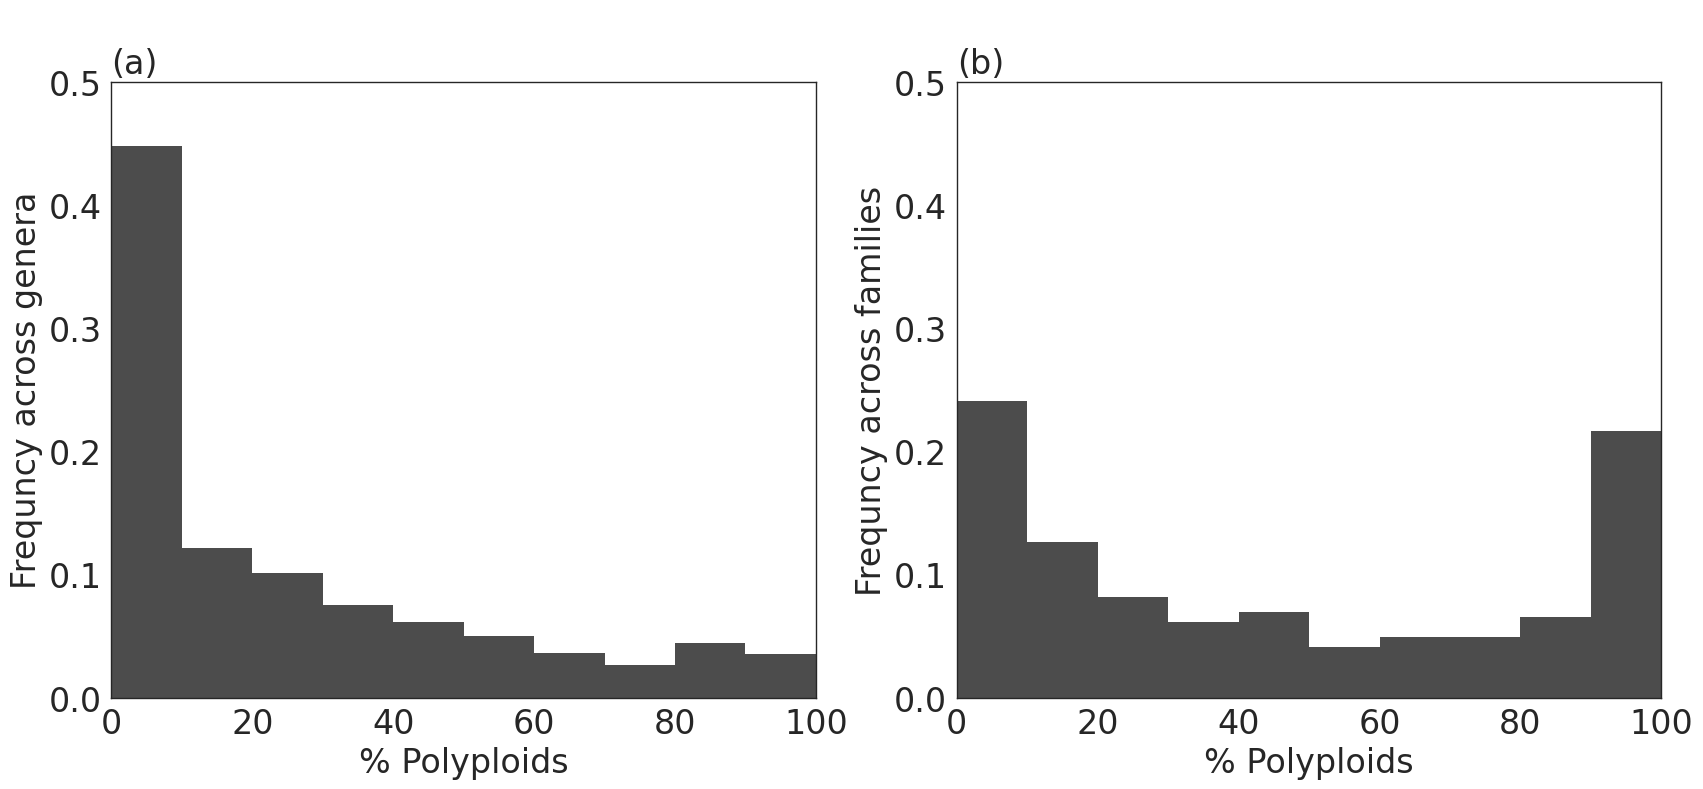

In [26]:
plt.rcParams.update({"font.size": 24, "font.weight": "normal", "axes.grid": False, "savefig.transparent": False})
sns.set_style("white")
colors = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3", "#999999", "#e41a1c", "#dede00"]
nbins = 10
fontsize = 24

genus_level_db = comb_to_db[False]["genus"].loc[comb_to_db[False]["genus"]["Ploidy inference"].notna()]
family_level_db = comb_to_db[False]["family"].loc[comb_to_db[False]["family"]["Ploidy inference"].notna()]

genus_level_db_by_genus = genus_level_db.groupby("genus")["Ploidy inference"].apply(
    lambda x: np.nansum(x) / len(x.dropna()) * 100
)
family_level_db_by_genus = family_level_db.groupby("Genus")["Ploidy inference"].apply(
    lambda x: np.nansum(x) / len(x.dropna()) * 100
)
print(f"# covered genera at genus level = {genus_level_db_by_genus.shape[0]:,}")
print(f"# covered geneta  at family level = {family_level_db_by_genus.shape[0]:,}")

genus_level_db_by_family = genus_level_db.groupby("Family")["Ploidy inference"].apply(
    lambda x: np.nansum(x) / len(x.dropna()) * 100
)
family_level_db_by_family = family_level_db.groupby("family")["Ploidy inference"].apply(
    lambda x: np.nansum(x) / len(x.dropna()) * 100
)
print(f"# covered families at genus level = {genus_level_db_by_family.shape[0]:,}")
print(f"# covered families  at family level = {family_level_db_by_family.shape[0]:,}")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

ax[0].set_title("(a)", fontsize=fontsize, loc="left")
sns.histplot(
    x=genus_level_db_by_genus,
    ax=ax[0],
    color="black",
    label="genus-level inference",
    bins=nbins,
    alpha=0.7,
    linewidth=0,
    stat="probability",
)
ax[0].set_ylabel("Frequncy across genera", fontsize=fontsize)
ax[0].set_xlabel("% Polyploids", fontsize=fontsize)
ax[0].set_ylim((0, 0.5))
ax[0].set_xlim((0, 100))

# ax[0][1].set_title("(b)", fontsize=20, loc='left')
# sns.histplot(x=genus_level_db_by_family,ax=ax[0][1], color=colors[0], label="genus-level inference", bins=nbins, alpha = 0.7, linewidth=0, stat="probability")
# ax[0][1].set_ylabel("Frequncy across families", fontsize=16)
# ax[0][1].set_xlabel("% Polyploids", fontsize=16)
# ax[0][1].set_ylim((0,0.6))
# ax[0][1].set_xlim((0,100))


# ax[1][0].set_title("\n(c)", fontsize=20, loc='left')
# sns.histplot(x=family_level_db_by_genus,ax=ax[1][0], color=colors[1], label="family-level inference", bins=nbins, alpha = 0.7, linewidth=0, stat="probability")
# ax[1][0].set_ylabel("Frequncy across genera", fontsize=16)
# ax[1][0].set_xlabel("% Polyploids", fontsize=16)
# ax[1][0].set_ylim((0,0.7))
# ax[1][0].set_xlim((0,100))

ax[1].set_title("\n(b)", fontsize=fontsize, loc="left")
sns.histplot(
    x=family_level_db_by_family,
    ax=ax[1],
    color="black",
    label="family-level inference",
    bins=nbins,
    alpha=0.7,
    linewidth=0,
    stat="probability",
)
ax[1].set_ylabel("Frequncy across families", fontsize=fontsize)
ax[1].set_xlabel("% Polyploids", fontsize=fontsize)
ax[1].set_ylim((0, 0.5))
ax[1].set_xlim((0, 100))

fig.savefig("Fig1.jpeg", transparent=True)

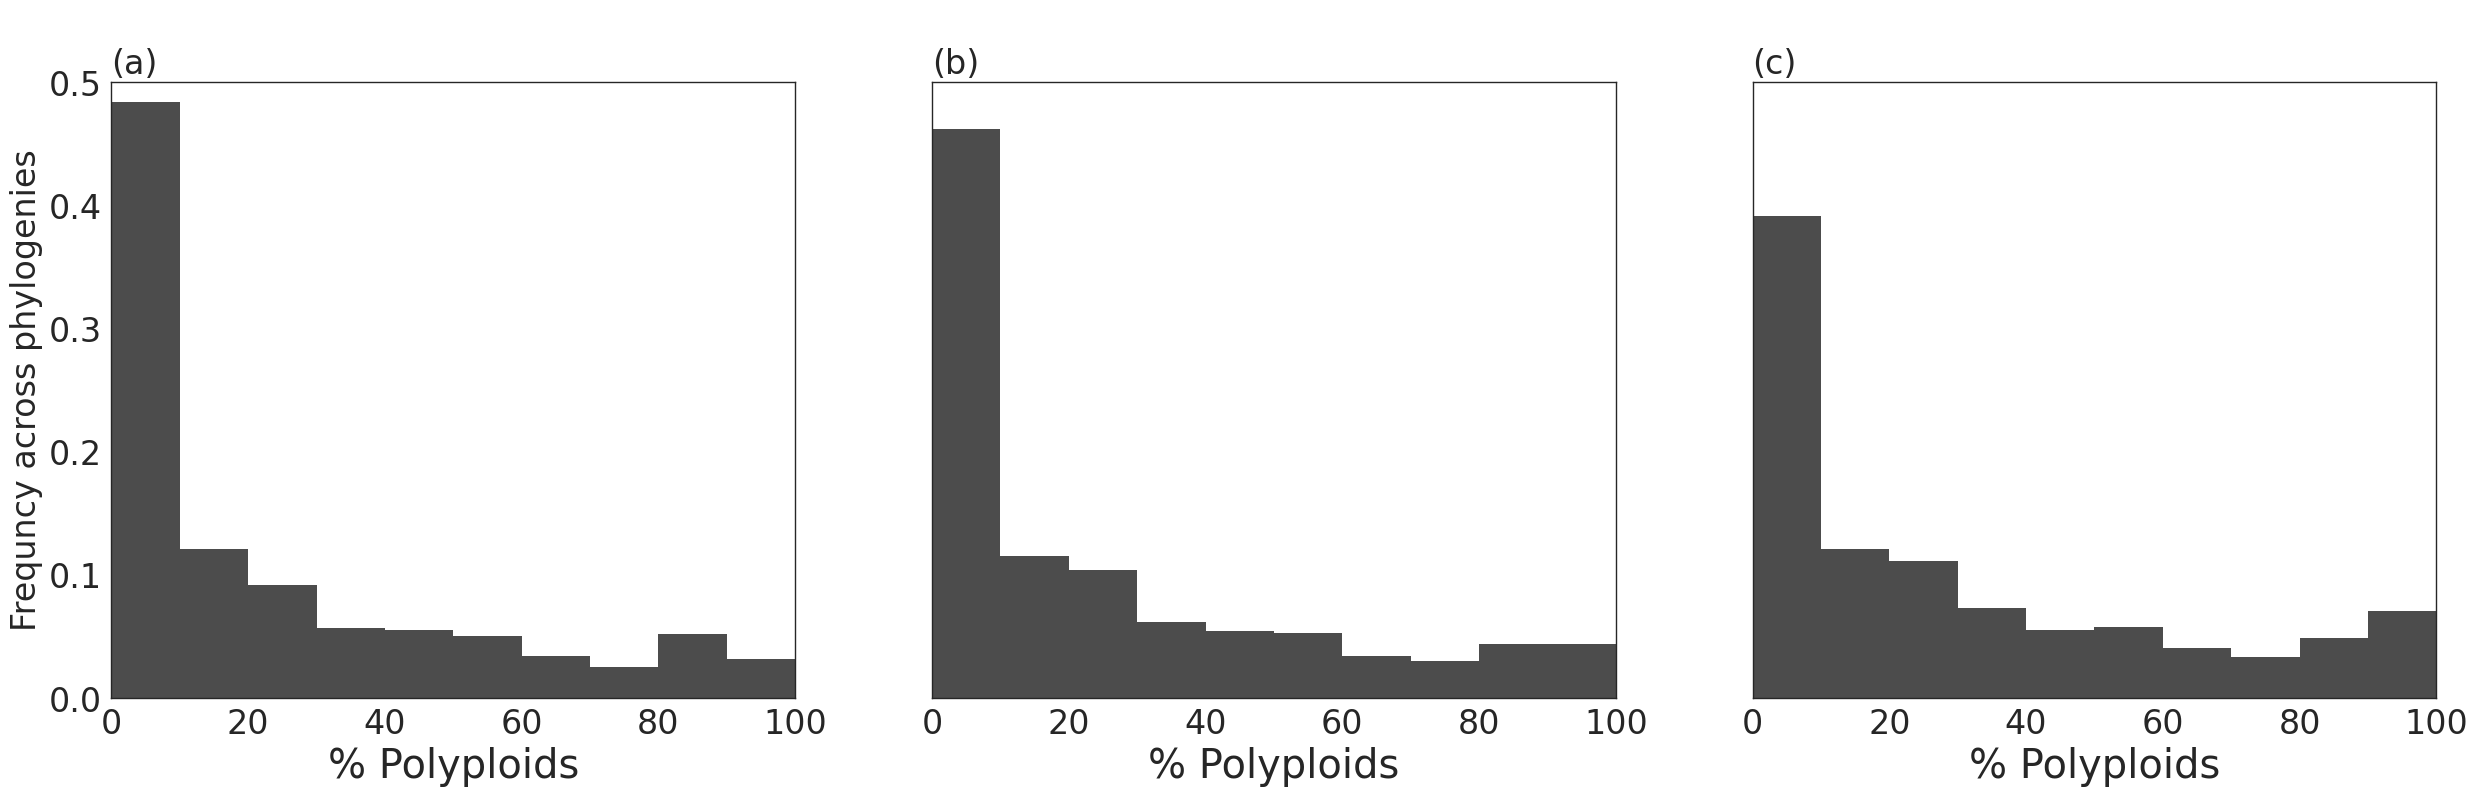

In [27]:
mya5_db = comb_to_db[False]["time_5"].dropna(subset=["Ploidy inference"])
mya10_db = comb_to_db[False]["time_10"].dropna(subset=["Ploidy inference"])
mya20_db = comb_to_db[False]["time_20"].dropna(subset=["Ploidy inference"])


mya5_db_grouped = (
    mya5_db.groupby("time_5")["Ploidy inference"]
    .apply(lambda x: np.nansum(x) / len(x.dropna()) * 100)
    .rename("% Polyploids")
)
mya10_db_grouped = (
    mya10_db.groupby("time_10")["Ploidy inference"]
    .apply(lambda x: np.nansum(x) / len(x.dropna()) * 100)
    .rename("% Polyploids")
)
mya20_db_grouped = (
    mya20_db.groupby("time_20")["Ploidy inference"]
    .apply(lambda x: np.nansum(x) / len(x.dropna()) * 100)
    .rename("% Polyploids")
)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 8), sharey=True, sharex=True)

ax[0].set_title("(a)", fontsize=fontsize, loc="left")
sns.histplot(
    x=mya5_db_grouped,
    ax=ax[0],
    color="black",
    label="5 MYA-level inference",
    bins=nbins,
    alpha=0.7,
    linewidth=0,
    stat="probability",
)
ax[0].set_ylabel("Frequncy across phylogenies", fontsize=fontsize)
ax[0].set_ylim((0, 0.5))
ax[0].set_xlim((0, 100))

ax[1].set_title("\n(b)", fontsize=fontsize, loc="left")
sns.histplot(
    x=mya10_db_grouped,
    ax=ax[1],
    color="black",
    label="10 MYA-level inference",
    bins=nbins,
    alpha=0.7,
    linewidth=0,
    stat="probability",
)
ax[1].set_ylim((0, 0.5))
ax[1].set_xlim((0, 100))

ax[2].set_title("\n(c)", fontsize=fontsize, loc="left")
sns.histplot(
    x=mya20_db_grouped,
    ax=ax[2],
    color="black",
    label="20 MYA-level inference",
    bins=nbins,
    alpha=0.7,
    linewidth=0,
    stat="probability",
)
ax[2].set_ylim((0, 0.5))
ax[2].set_xlim((0, 100))

fig.savefig("FigS1.jpeg", transparent=True)

In [28]:
all_angio_families = set(
    classification_data_by_major_group.get_group("angiosperms")
    .query("taxonRank == 'FAMILY'")
    .scientificName.str.lower()
    .unique()
)
covered_angio_families = set(genus_level_db_by_family.index)
print(f"# angiosperm families in wfo = {len(all_angio_families):,}")
print(f"# angiosperm families in ploidb at genus level = {len(covered_angio_families):,}")
intersection = all_angio_families & covered_angio_families
print(f"# families in both data sources = {len(intersection):,}")

# angiosperm families in wfo = 419
# angiosperm families in ploidb at genus level = 220
# families in both data sources = 208


In [29]:
all_families = set(classification_data.query("taxonRank == 'FAMILY'").scientificName.str.lower().unique())
covered_families = set(genus_level_db_by_family.index)
print(f"# families in wfo = {len(all_families):,}")
print(f"# families in ploidb at genus level = {len(covered_families):,}")
intersection = all_families & covered_families
print(f"# families in both data sources = {len(intersection):,}")

# families in wfo = 719
# families in ploidb at genus level = 220
# families in both data sources = 216


In [30]:
sp_and_under_classification_data = classification_data.loc[
    classification_data.taxonRank.isin(
        ["SPECIES", "SUBSPECIES", "VARIETY", "FORM", "SUBVARIETY", "SUBFORM", "SECTION", "SUBSECTION"]
    )
]
wfo_family_to_size = sp_and_under_classification_data.groupby("family").scientificName.count().to_dict()

In [31]:
genus_level_db_by_family = genus_level_db_by_family.reset_index()
genus_level_db_by_family["n_covered_taxa"] = genus_level_db_by_family.Family.apply(
    lambda n: db.query(f"Family == '{n}'").shape[0]
)
genus_level_db_by_family["n_wfo_taxa"] = genus_level_db_by_family.Family.apply(
    lambda n: wfo_family_to_size.get(n, np.nan)
)
genus_level_db_by_family[f"frac_covered_taxa"] = genus_level_db_by_family.apply(
    lambda record: len(
        set(db.query(f"Family == '{record.Family}'").Taxon)
        & set(sp_and_under_classification_data.query(f"family == '{record.Family}'").scientificName.str.lower())
    )
    / record.n_wfo_taxa
    if record.n_wfo_taxa > 0
    else np.nan,
    axis=1,
)
genus_level_db_by_family[genus_level_db_by_family["Ploidy inference"] >= 80].sort_values(
    "Ploidy inference", ascending=False
).rename(columns={"Ploidy inference": "%polyploids"})

,Family,%polyploids,n_covered_taxa,n_wfo_taxa,frac_covered_taxa
102,juncaceae,98.305085,513,664.0,0.481928
148,pandanaceae,96.000000,610,1014.0,0.478304
116,loganiaceae,92.307692,249,528.0,0.375000
155,phytolaccaceae,91.666667,29,32.0,0.687500
168,portulacaceae,90.476190,163,120.0,0.666667
211,violaceae,90.461538,1104,1270.0,0.504724
182,sabiaceae,90.000000,162,190.0,0.384211
82,fouquieriaceae,80.000000,11,13.0,0.846154


# compute coverage stats and ploidy inference stats across phylogenetic scales

In [32]:
summary = pd.DataFrame(
    columns=[
        "Pipeline state",
        "Phylogenetic scale",
        "Coverage",
        "Angispems coverage",
        "Gymnosperms coverage",
        "# Focal clades",
        "# Genera",
        "# Families",
        # "% Clades with complete diploidy inference",
        # "% Clades with complete polyploidy inference",
        # "% Clades that failed the stochastic mappngs step",
        # "% Diploids",
        "% Polyploids",
        "% Undetermined",
    ]
)
for am in add_missing_options:
    for gb in group_by_options:
        try:
            db = comb_to_db[am][gb]
            db.major_group.fillna("angiosperms", inplace=True)
            # db = db.dropna(subset=["Ploidy inference"])
            num_clades = len(db.loc[db["Ploidy inference"].notna(), gb].unique())
            summ = {
                "Pipeline state": ["1" if not am else "2"],
                "Phylogenetic scale": [gb.replace("time_", "").capitalize() + (" MYA" if "time" in gb else "")],
                "Coverage": [db.loc[db["Ploidy inference"].notna()].shape[0]],
                "Angispems coverage": [
                    db.loc[db["Ploidy inference"].notna()]
                    .query("major_group == 'angiosperms'")
                    .drop_duplicates("Taxon")
                    .shape[0]
                ],
                "Gymnosperms coverage": [
                    db.loc[db["Ploidy inference"].notna()]
                    .query("major_group == 'gymnosperms'")
                    .drop_duplicates("Taxon")
                    .shape[0]
                ],
                "# Genera": [len(db.loc[db["Ploidy inference"].notna()].Genus.unique())],
                "# Families": [
                    len(
                        db.loc[db["Ploidy inference"].notna()][
                            "family" if "family" in db.columns else "Family"
                        ].unique()
                    )
                ],
                "# Focal clades": [num_clades],
                # "% Clades with complete diploidy inference": [len(stats["only_di"])/num_clades*100],
                # "% Clades with complete polyploidy inference": [len(stats["only_poly"])/num_clades*100],
                # "% Clades that failed the stochastic mappngs step": [len(stats["failed_map"])/num_clades*100],
                # "% Diploids": [np.round(db.loc[db["Ploidy inference"] == 0].shape[0] / db.shape[0] * 100, 2)],
                "% Polyploids": [
                    np.round(
                        db.loc[db["Ploidy inference"] == 1].shape[0]
                        / db.loc[db["Ploidy inference"].notna()].shape[0]
                        * 100,
                        2,
                    )
                ],
                "% Undetermined": [np.round(db.loc[db["Ploidy inference"].isna()].shape[0] / db.shape[0] * 100, 2)],
            }
            summary = pd.concat([summary, pd.DataFrame(summ)])
        except:
            pass

summary.to_csv("pipeline_stats.csv", index=False)
display(summary)

,Pipeline state,Phylogenetic scale,Coverage,Angispems coverage,Gymnosperms coverage,# Focal clades,# Genera,# Families,% Polyploids,% Undetermined
0,1,Genus,56595,56153,442,2062,2062,220,31.56,1.44
0,1,Family,63168,62631,537,245,6210,245,59.38,4.72
0,1,5 MYA,25418,25165,253,1330,1871,145,33.64,0.87
0,1,10 MYA,41434,41080,354,1432,3266,192,37.23,1.5
0,1,20 MYA,52100,51632,455,994,4480,215,46.78,7.69
0,2,Genus,99728,98067,270,1359,1359,196,23.41,42.94


# compute coverage and polyploids distribution across different classification categories

In [33]:
scale_of_interest = "genus"
mg_groups = ["angiosperms", "gymnosperms"]
cots_groups = list(cot_classes)

classification_data_by_major_group = classification_data.groupby("majorGroup")
mg_coverage = pd.DataFrame({"Major group": mg_groups})
cot_coverage = pd.DataFrame({"Cot": cots_groups})

angio_families["ccdb_covered_names"] = angio_families.family.apply(get_ccdb_coverage)
angio_families.query("ccdb_covered_names < 10 and num_accepted_names > 200").sort_values(["ccdb_covered_names"])
angio_families = angio_families.loc[(~angio_families.family.isin(["cyperaceae", "cuscuteae", "juncaceae"]))]
largest_angio_families = angio_families.sort_values("num_accepted_names", ascending=False).family.tolist()

angio_coverage = pd.DataFrame({"Family": largest_angio_families})

for am in [False, True]:
    db = comb_to_db[am][scale_of_interest]
    db["major_group"].fillna("angiosperms", inplace=True)
    db = db.loc[db["Ploidy inference"].notna()]
    state = 1 if not am else 2
    ns = db.shape[0]
    ng = len(db.Genus.unique())
    nf = len(db.Family.unique())

    print(f"with{'out' if not am else ''} missing data\n# species = {ns:,}\n# genera = {ng:,}\n# families = {nf:,}\n")

    cot_coverage[f"Number of taxa in state ({state})"] = np.nan
    cot_coverage[f"% Polyploids in state ({state})"] = np.nan
    for cot in cots_groups:
        covered_taxa = db.loc[db.cot_class == cot].Taxon.unique().tolist()
        db_polyploids = set(
            db.loc[(db.Taxon.str.lower().isin(covered_taxa)) & (db["Ploidy inference"] == 1)].Taxon.unique().tolist()
        )
        db_diploids = set(
            db.loc[(db.Taxon.str.lower().isin(covered_taxa)) & (db["Ploidy inference"] == 0)].Taxon.unique().tolist()
        )
        cot_coverage.loc[cot_coverage["Cot"] == cot, f"Number of taxa in state ({state})"] = len(covered_taxa)
        cot_coverage.loc[cot_coverage["Cot"] == cot, f"% Polyploids in state ({state})"] = np.round(
            len(db_polyploids) / (len(db_diploids) + len(db_polyploids) + 0.0001) * 100, 3
        )

    mg_coverage[f"Major group size"] = np.nan
    mg_coverage[f"Number of taxa in state ({state})"] = np.nan
    mg_coverage[f"% Polyploids in state ({state})"] = np.nan
    mg_coverage[f"Coverage in state ({state})"] = np.nan
    for mg in mg_groups:

        wfo_taxa = set(classification_data_by_major_group.get_group(mg).taxon.str.lower().unique().tolist())
        db_taxa = set(db.Taxon.str.lower().unique().tolist())
        # covered_taxa = list(wfo_taxa & db_taxa)
        covered_taxa = db.loc[db.major_group == mg].Taxon.unique().tolist()
        db_polyploids = set(
            db.loc[(db.Taxon.str.lower().isin(covered_taxa)) & (db["Ploidy inference"] == 1)].Taxon.unique().tolist()
        )
        db_diploids = set(
            db.loc[(db.Taxon.str.lower().isin(covered_taxa)) & (db["Ploidy inference"] == 0)].Taxon.unique().tolist()
        )

        mg_coverage.loc[mg_coverage["Major group"] == mg, "Major group size"] = len(wfo_taxa)
        mg_coverage.loc[mg_coverage["Major group"] == mg, f"Number of taxa in state ({state})"] = len(covered_taxa)
        mg_coverage.loc[mg_coverage["Major group"] == mg, f"% Polyploids in state ({state})"] = np.round(
            len(db_polyploids) / (len(db_diploids) + len(db_polyploids) + 0.0001) * 100, 3
        )
        mg_coverage.loc[mg_coverage["Major group"] == mg, f"Coverage in state ({state})"] = np.round(
            len(covered_taxa) / len(wfo_taxa) * 100, 2
        )

    angio_coverage["Species richness"] = np.nan
    angio_coverage[f"Coverage in state ({state})"] = np.nan
    angio_coverage[f"%Polyploids in state ({state})"] = np.nan
    for fam in largest_angio_families:
        wfo_taxa = set(classification_data.query(f"family == '{fam}'").taxon.str.lower().tolist())
        db_taxa = set(db.Taxon.str.lower().unique().tolist())
        covered_taxa = db.loc[db.Family == fam].Taxon.unique().tolist()
        db_polyploids = set(
            db.loc[(db.Taxon.str.lower().isin(covered_taxa)) & (db["Ploidy inference"] == 1)].Taxon.unique().tolist()
        )
        db_diploids = set(
            db.loc[(db.Taxon.str.lower().isin(covered_taxa)) & (db["Ploidy inference"] == 0)].Taxon.unique().tolist()
        )

        angio_coverage.loc[angio_coverage["Family"] == fam, "Species richness"] = len(wfo_taxa)
        angio_coverage.loc[angio_coverage["Family"] == fam, f"Coverage in state ({state})"] = len(covered_taxa)
        angio_coverage.loc[angio_coverage["Family"] == fam, f"%Polyploids in state ({state})"] = np.round(
            len(db_polyploids) / (len(db_diploids) + len(db_polyploids) + 0.0001) * 100, 3
        )

mg_coverage["Major group"] = mg_coverage["Major group"].str.capitalize()
mg_coverage.to_csv(f"major_groups_coverage_at_{scale_of_interest}_inference_level.csv")
angio_coverage.Family = angio_coverage.Family.str.capitalize()
angio_coverage.to_csv(f"angiosperm_coverage_at_{scale_of_interest}_inference_level.csv")


print(f"results of inference scheme at {scale_of_interest} level:\n")
print(f"coverage across cot groups:")
display(cot_coverage)
print(f"coverage across major groups:")
display(mg_coverage)
print(f"\ncoverage across angiosperms families:")
display(angio_coverage.sort_values("%Polyploids in state (1)", ascending=False))

without missing data
# species = 56,595
# genera = 2,062
# families = 220

with missing data
# species = 99,728
# genera = 1,359
# families = 196

results of inference scheme at genus level:

coverage across cot groups:


,Cot,Number of taxa in state (1),% Polyploids in state (1),Number of taxa in state (2),% Polyploids in state (2)
0,Basal dicots (non-asterid +non-rosid dicots),6791.0,36.858,9993.0,29.531
1,Basal angiosperms,557.0,23.878,1714.0,11.960
2,Dicots - core asterids,23168.0,30.780,36944.0,20.239
3,Higher monocots (commelinids),4693.0,49.329,8402.0,45.513
4,Dicots - core rosids,14021.0,30.461,23869.0,23.759
5,Basal monocots (non-commelinid monocots),6722.0,21.541,16691.0,16.949


coverage across major groups:


,Major group,Major group size,Number of taxa in state (1),% Polyploids in state (1),Coverage in state (1),Number of taxa in state (2),% Polyploids in state (2),Coverage in state (2)
0,Angiosperms,389367.0,56153.0,31.760,14.42,98067.0,23.454,25.19
1,Gymnosperms,1643.0,442.0,5.656,26.90,270.0,9.630,16.43



coverage across angiosperms families:


,Family,Species richness,Coverage in state (1),%Polyploids in state (1),Coverage in state (2),%Polyploids in state (2)
74,Pandanaceae,1018.0,25.0,96.000,608.0,0.164
104,Loganiaceae,542.0,39.0,92.307,39.0,92.307
236,Phytolaccaceae,37.0,12.0,91.666,12.0,91.666
175,Portulacaceae,126.0,21.0,90.476,163.0,86.503
61,Violaceae,1290.0,325.0,90.462,1093.0,97.072
...,...,...,...,...,...,...
254,Dasypogonaceae,25.0,0.0,0.000,0.0,0.000
255,Basellaceae,25.0,0.0,0.000,0.0,0.000
256,Gyrostemonaceae,25.0,0.0,0.000,0.0,0.000
257,Cymodoceaceae,24.0,0.0,0.000,0.0,0.000


In [34]:
db = comb_to_db[False]["genus"].copy()
db = (
    db.groupby("genus")[["Taxon", "Ploidy inference", "major_group"]]
    .agg({"Taxon": lambda x: len(x), "Ploidy inference": sum, "major_group": lambda x: x.values[0]})
    .reset_index()
    .rename(columns={"Taxon": "ntaxa", "Ploidy inference": "npolyploids"})
)
db["%polyploids"] = db.apply(lambda rec: rec.npolyploids / rec.ntaxa * 100, axis=1)
print(
    f"# polyploids-rich angiosperm genera = {db.loc[(db.major_group == 'angiosperms') & (db['%polyploids'] > 50)].shape[0]:,}"
)
print(
    f"# polyploids-rich gymnosperm genera = {db.loc[(db.major_group == 'gymnosperms') & (db['%polyploids'] > 50)].shape[0]:,}"
)

# polyploids-rich angiosperm genera = 351
# polyploids-rich gymnosperm genera = 0


In [35]:
genus_level_db_by_genus = genus_level_db_by_genus.reset_index()
db.loc[
    (db.genus.isin(genus_level_db_by_genus.loc[genus_level_db_by_genus["Ploidy inference"] > 50].genus.unique()))
    & (db.major_group == "gymnosperms")
].genus.unique().tolist()

[]

In [36]:
uncovered_families = (
    comb_to_db[False]["family"]
    .query("flag == 'incomplete job' or flag == 'failed due to mappings'")["family"]
    .unique()
    .tolist()
)

genus_db = comb_to_db[False]["genus"]
genus_db = genus_db.loc[~genus_db.Family.isin(uncovered_families)]
family_db = comb_to_db[False]["family"]
in_genus_not_in_family = list(set(genus_db.Taxon.unique()) - set(family_db.Taxon.unique()))
in_family_not_in_genus = list(set(family_db.Taxon.unique()) - set(genus_db.Taxon.unique()))

In [37]:
print(
    f"# species included in the genus-level analysis but not in the family-level analysis = {len(in_genus_not_in_family):,}"
)
print(
    f"# species included in the family-level analysis but not in the genus-level analysis = {len(in_family_not_in_genus):,}"
)

missing_families_from_family_analysis = (
    genus_db.loc[genus_db.Taxon.isin(in_genus_not_in_family)].sort_values("Family").Family.unique().tolist()
)
print(f"# families of the species missing from the family analysis = {len(missing_families_from_family_analysis):,}")
partially_covered_families = list(
    family_db.loc[family_db.Family.isin(missing_families_from_family_analysis)].Family.unique()
)
print(f"# families that are partially covered in the family analysis = {len(partially_covered_families):,}")

uncovered_families = list(set(missing_families_from_family_analysis) - set(partially_covered_families))
print(f"uncovered_families={uncovered_families}")
print(f"partially_covered_families={partially_covered_families}")

# species included in the genus-level analysis but not in the family-level analysis = 318
# species included in the family-level analysis but not in the genus-level analysis = 9,190
# families of the species missing from the family analysis = 13
# families that are partially covered in the family analysis = 9
uncovered_families=['lemnaceae', 'xanthorrhoeaceae', 'leguminosae', 'adoxaceae']
partially_covered_families=['liliaceae', 'proteaceae', 'loganiaceae', 'scrophulariaceae', 'asteraceae', 'asparagaceae', 'plantaginaceae', 'linderniaceae', 'primulaceae']
